In [1]:
from helper_functions import *
from plots import *

xp = gwpop.cupy_utils.xp

In [2]:
luminosity_distances = np.linspace(1, 50000, 1000)
redshifts = np.array([cosmo.z_at_value(Planck15.luminosity_distance, 
                                                   dl * u.Mpc) for dl in luminosity_distances])
dl_to_z = interp1d(luminosity_distances, redshifts)
luminosity_prior = luminosity_distances ** 2
dz_ddl = np.gradient(redshifts, luminosity_distances)

redshift_prior = interp1d(redshifts, luminosity_prior / dz_ddl / (1 + redshifts))

### Posteriors

In [3]:
## Only run this to load posteriors if they have already been calculated

posteriors = list()
for filename in glob.glob('../processed_samples/OverallPosteriors/*'):
    _posterior = pd.read_csv(filename)
    posteriors.append(_posterior)

In [4]:
BOUNDS = dict(
    mass_1=(2, 100),
    mass_ratio=(0, 1),
    a_1=(0, 1),
    a_2=(0, 1),
    cos_tilt_1=(-1, 1),
    cos_tilt_2=(-1, 1),
    redshift=(0, 2.3))

PRIOR_VOLUME = (
    (BOUNDS["mass_1"][1] - BOUNDS["mass_1"][0]) ** 2
    * (BOUNDS["a_1"][1] - BOUNDS["a_1"][0])
    * (BOUNDS["a_2"][1] - BOUNDS["a_2"][0])
    * (BOUNDS["cos_tilt_1"][1] - BOUNDS["cos_tilt_1"][0])
    * (BOUNDS["cos_tilt_2"][1] - BOUNDS["cos_tilt_2"][0])) / 2

for posterior in posteriors:
    del posterior["chi_eff"]
    del posterior["chi_p"]
    del posterior["joint_prior"]
    posterior["spin_prior"] = 1/4
    posterior["mass_spin_prior"] = (posterior["mass_1"] * (1 + posterior["redshift"])**2)/PRIOR_VOLUME
    posterior["redshift_prior"] = redshift_prior(posterior['redshift'])

### Default Model without selection effects

In [5]:
model = bilby.hyper.model.Model([mass.SinglePeakSmoothedMassDistribution(),
                                 spin.iid_spin_default,
                                 redshift.PowerLawRedshift()])

for posterior in posteriors:
    posterior["prior"] = posterior["mass_spin_prior"] * posterior["redshift_prior"]

In [6]:
def prior_conversion1(parameters):
    mu = parameters["mu_chi"]
    var = parameters["sigma_chi"]
    parameters["alpha_chi"] = (mu ** 2 * (1 - mu) - mu * var) / var
    parameters["beta_chi"] = (mu * (1 - mu) ** 2 - (1 - mu) * var) / var
    return parameters

def prior_conversion2(parameters):
    mu = parameters["mu_chi"]
    var = parameters["sigma_chi"]
    added_keys = pd.DataFrame()
    parameters["alpha_chi"] = (mu ** 2 * (1 - mu) - mu * var) / var
    parameters["beta_chi"] = (mu * (1 - mu) ** 2 - (1 - mu) * var) / var
    added_keys["alpha_chi"] = parameters["alpha_chi"]
    added_keys["beta_chi"] = parameters["beta_chi"]
    return parameters, added_keys

In [7]:
priors = PriorDict(conversion_function = prior_conversion1)

# rate 
priors["rate"] = LogUniform(minimum=1e-1, maximum=1e3, latex_label=r'$R$', boundary="reflective")

# mass
priors["alpha"] = Uniform(minimum=-4., maximum=12., latex_label=r'$\alpha$', boundary='reflective')
priors["beta"] = Uniform(minimum=-4., maximum=12., latex_label=r'$\beta_q$')
priors['delta_m'] = Uniform(minimum=0., maximum=10., latex_label=r'$\delta_m$ $[M_\odot]$')
priors["mmin"] = Uniform(minimum=2., maximum=10., latex_label=r'$m_\mathrm{min}$ $[M_\odot]$')
priors['mmax'] = Uniform(minimum=30., maximum=100., latex_label=r'$m_\mathrm{max}$ $[M_\odot]$')
priors['lam'] = Uniform(minimum=0., maximum=1., latex_label=r'$\lambda_\mathrm{peak}$')
priors['mpp'] = Uniform(minimum=20., maximum=50., latex_label=r'$\mu_m$ $[M_\odot]$')
priors['sigpp'] = Uniform(minimum=0.4, maximum=10., latex_label=r'$\sigma_m$ $[M_\odot]$')

# spin magnitude 
priors["mu_chi"] = Uniform(minimum = 0, maximum = 1, latex_label = r'$\mu_\chi$')
priors["sigma_chi"] = Uniform(minimum = 0, maximum = 0.25, latex_label = r'$\sigma^2_\chi$')
priors["amax"] = 1
priors["alpha_chi"] = Constraint(minimum = 1, maximum = 1e5)
priors["beta_chi"] = Constraint(minimum = 1, maximum = 1e5)

# spin orientation
priors["xi_spin"] = Uniform(minimum = 0, maximum = 1, latex_label=r'$\zeta$')
priors["sigma_spin"] = Uniform(minimum = 0.01, maximum = 4, latex_label=r'$\sigma_t$')

# redshift
priors["lamb"] = Uniform(minimum=-6, maximum=6, name='lamb', latex_label="$\\lambda_z$")

In [8]:
likelihood = gwpop.hyperpe.RateLikelihood(posteriors = posteriors, 
                                          hyper_prior = model,
                                          conversion_function = prior_conversion2)

In [9]:
likelihood.parameters.update(priors.sample())

In [10]:
result = bilby.run_sampler(likelihood = likelihood, priors = priors, sampler='dynesty', 
                           nlive = 1000, label='default_spin_mass_redshift', 
                           outdir = 'Results/default_spin_mass_redshift', clean = True)

08:53 bilby INFO    : Running for label 'default_spin_mass_redshift', output will be saved to 'Results/default_spin_mass_redshift'
08:53 bilby INFO    : Search parameters:
08:53 bilby INFO    :   rate = LogUniform(minimum=0.1, maximum=1000.0, name=None, latex_label='$R$', unit=None, boundary='reflective')
08:53 bilby INFO    :   alpha = Uniform(minimum=-4.0, maximum=12.0, name=None, latex_label='$\\alpha$', unit=None, boundary='reflective')
08:53 bilby INFO    :   beta = Uniform(minimum=-4.0, maximum=12.0, name=None, latex_label='$\\beta_q$', unit=None, boundary=None)
08:53 bilby INFO    :   delta_m = Uniform(minimum=0.0, maximum=10.0, name=None, latex_label='$\\delta_m$ $[M_\\odot]$', unit=None, boundary=None)
08:53 bilby INFO    :   mmin = Uniform(minimum=2.0, maximum=10.0, name=None, latex_label='$m_\\mathrm{min}$ $[M_\\odot]$', unit=None, boundary=None)
08:53 bilby INFO    :   mmax = Uniform(minimum=30.0, maximum=100.0, name=None, latex_label='$m_\\mathrm{max}$ $[M_\\odot]$', unit=

0it [00:00, ?it/s]

08:53 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 600, 'nlive': 1000, 'first_update': None, 'walks': 100, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 600, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x7f6ae8ba0bb0>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5}
08:53 bilby INFO    : Checkpoint every check_point_delta_t = 600s
08:53 bilby INFO    : Using dynesty version 1.0.1
08:53 bilby INFO    : Using the bilby-implemented rwalk sam

/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/dynesty/plotting.py:245: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  axes[i].set_ylim([ymin, ymax])
12:35 bilby INFO    : Written checkpoint file Results/default_spin_mass_redshift/default_spin_mass_redshift_resume.pickle
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/dynesty/plotting.py:245: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  axes[i].set_ylim([ymin, ymax])
12:45 bilby INFO    : Written checkpoint file Results/default_spin_mass_redshift/default_spin_mass_redshift_resume.pickle
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/dynesty/plotting.py:245: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  axes[i].set_ylim([ymin, ymax])


/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/dynesty/plotting.py:245: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  axes[i].set_ylim([ymin, ymax])
16:19 bilby INFO    : Written checkpoint file Results/default_spin_mass_redshift/default_spin_mass_redshift_resume.pickle
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/dynesty/plotting.py:245: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  axes[i].set_ylim([ymin, ymax])
16:29 bilby INFO    : Written checkpoint file Results/default_spin_mass_redshift/default_spin_mass_redshift_resume.pickle
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/dynesty/plotting.py:245: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  axes[i].set_ylim([ymin, ymax])


/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/dynesty/plotting.py:245: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  axes[i].set_ylim([ymin, ymax])
20:04 bilby INFO    : Written checkpoint file Results/default_spin_mass_redshift/default_spin_mass_redshift_resume.pickle
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/dynesty/plotting.py:245: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  axes[i].set_ylim([ymin, ymax])
20:14 bilby INFO    : Written checkpoint file Results/default_spin_mass_redshift/default_spin_mass_redshift_resume.pickle
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/dynesty/plotting.py:245: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  axes[i].set_ylim([ymin, ymax])


/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/dynesty/plotting.py:245: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  axes[i].set_ylim([ymin, ymax])
23:51 bilby INFO    : Written checkpoint file Results/default_spin_mass_redshift/default_spin_mass_redshift_resume.pickle
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/dynesty/plotting.py:245: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  axes[i].set_ylim([ymin, ymax])
00:02 bilby INFO    : Written checkpoint file Results/default_spin_mass_redshift/default_spin_mass_redshift_resume.pickle
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/dynesty/plotting.py:245: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  axes[i].set_ylim([ymin, ymax])


02:59 bilby INFO    : Written checkpoint file Results/default_spin_mass_redshift/default_spin_mass_redshift_resume.pickle
02:59 bilby INFO    : Writing 2038 current samples to Results/default_spin_mass_redshift/default_spin_mass_redshift_samples.dat
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/dynesty/plotting.py:245: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  axes[i].set_ylim([ymin, ymax])
03:09 bilby INFO    : Written checkpoint file Results/default_spin_mass_redshift/default_spin_mass_redshift_resume.pickle
03:09 bilby INFO    : Writing 3113 current samples to Results/default_spin_mass_redshift/default_spin_mass_redshift_samples.dat
/home/deepnika.jain/anaconda3/envs/gwspin/lib/python3.8/site-packages/dynesty/plotting.py:245: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  axes[i].set_ylim([ymin, yma

04:02 bilby INFO    : Sampling time: 19:07:44.017783
04:02 bilby INFO    : Summary of results:
nsamples: 25769
ln_noise_evidence:    nan
ln_evidence:    nan +/-  0.188
ln_bayes_factor: -863.508 +/-  0.188



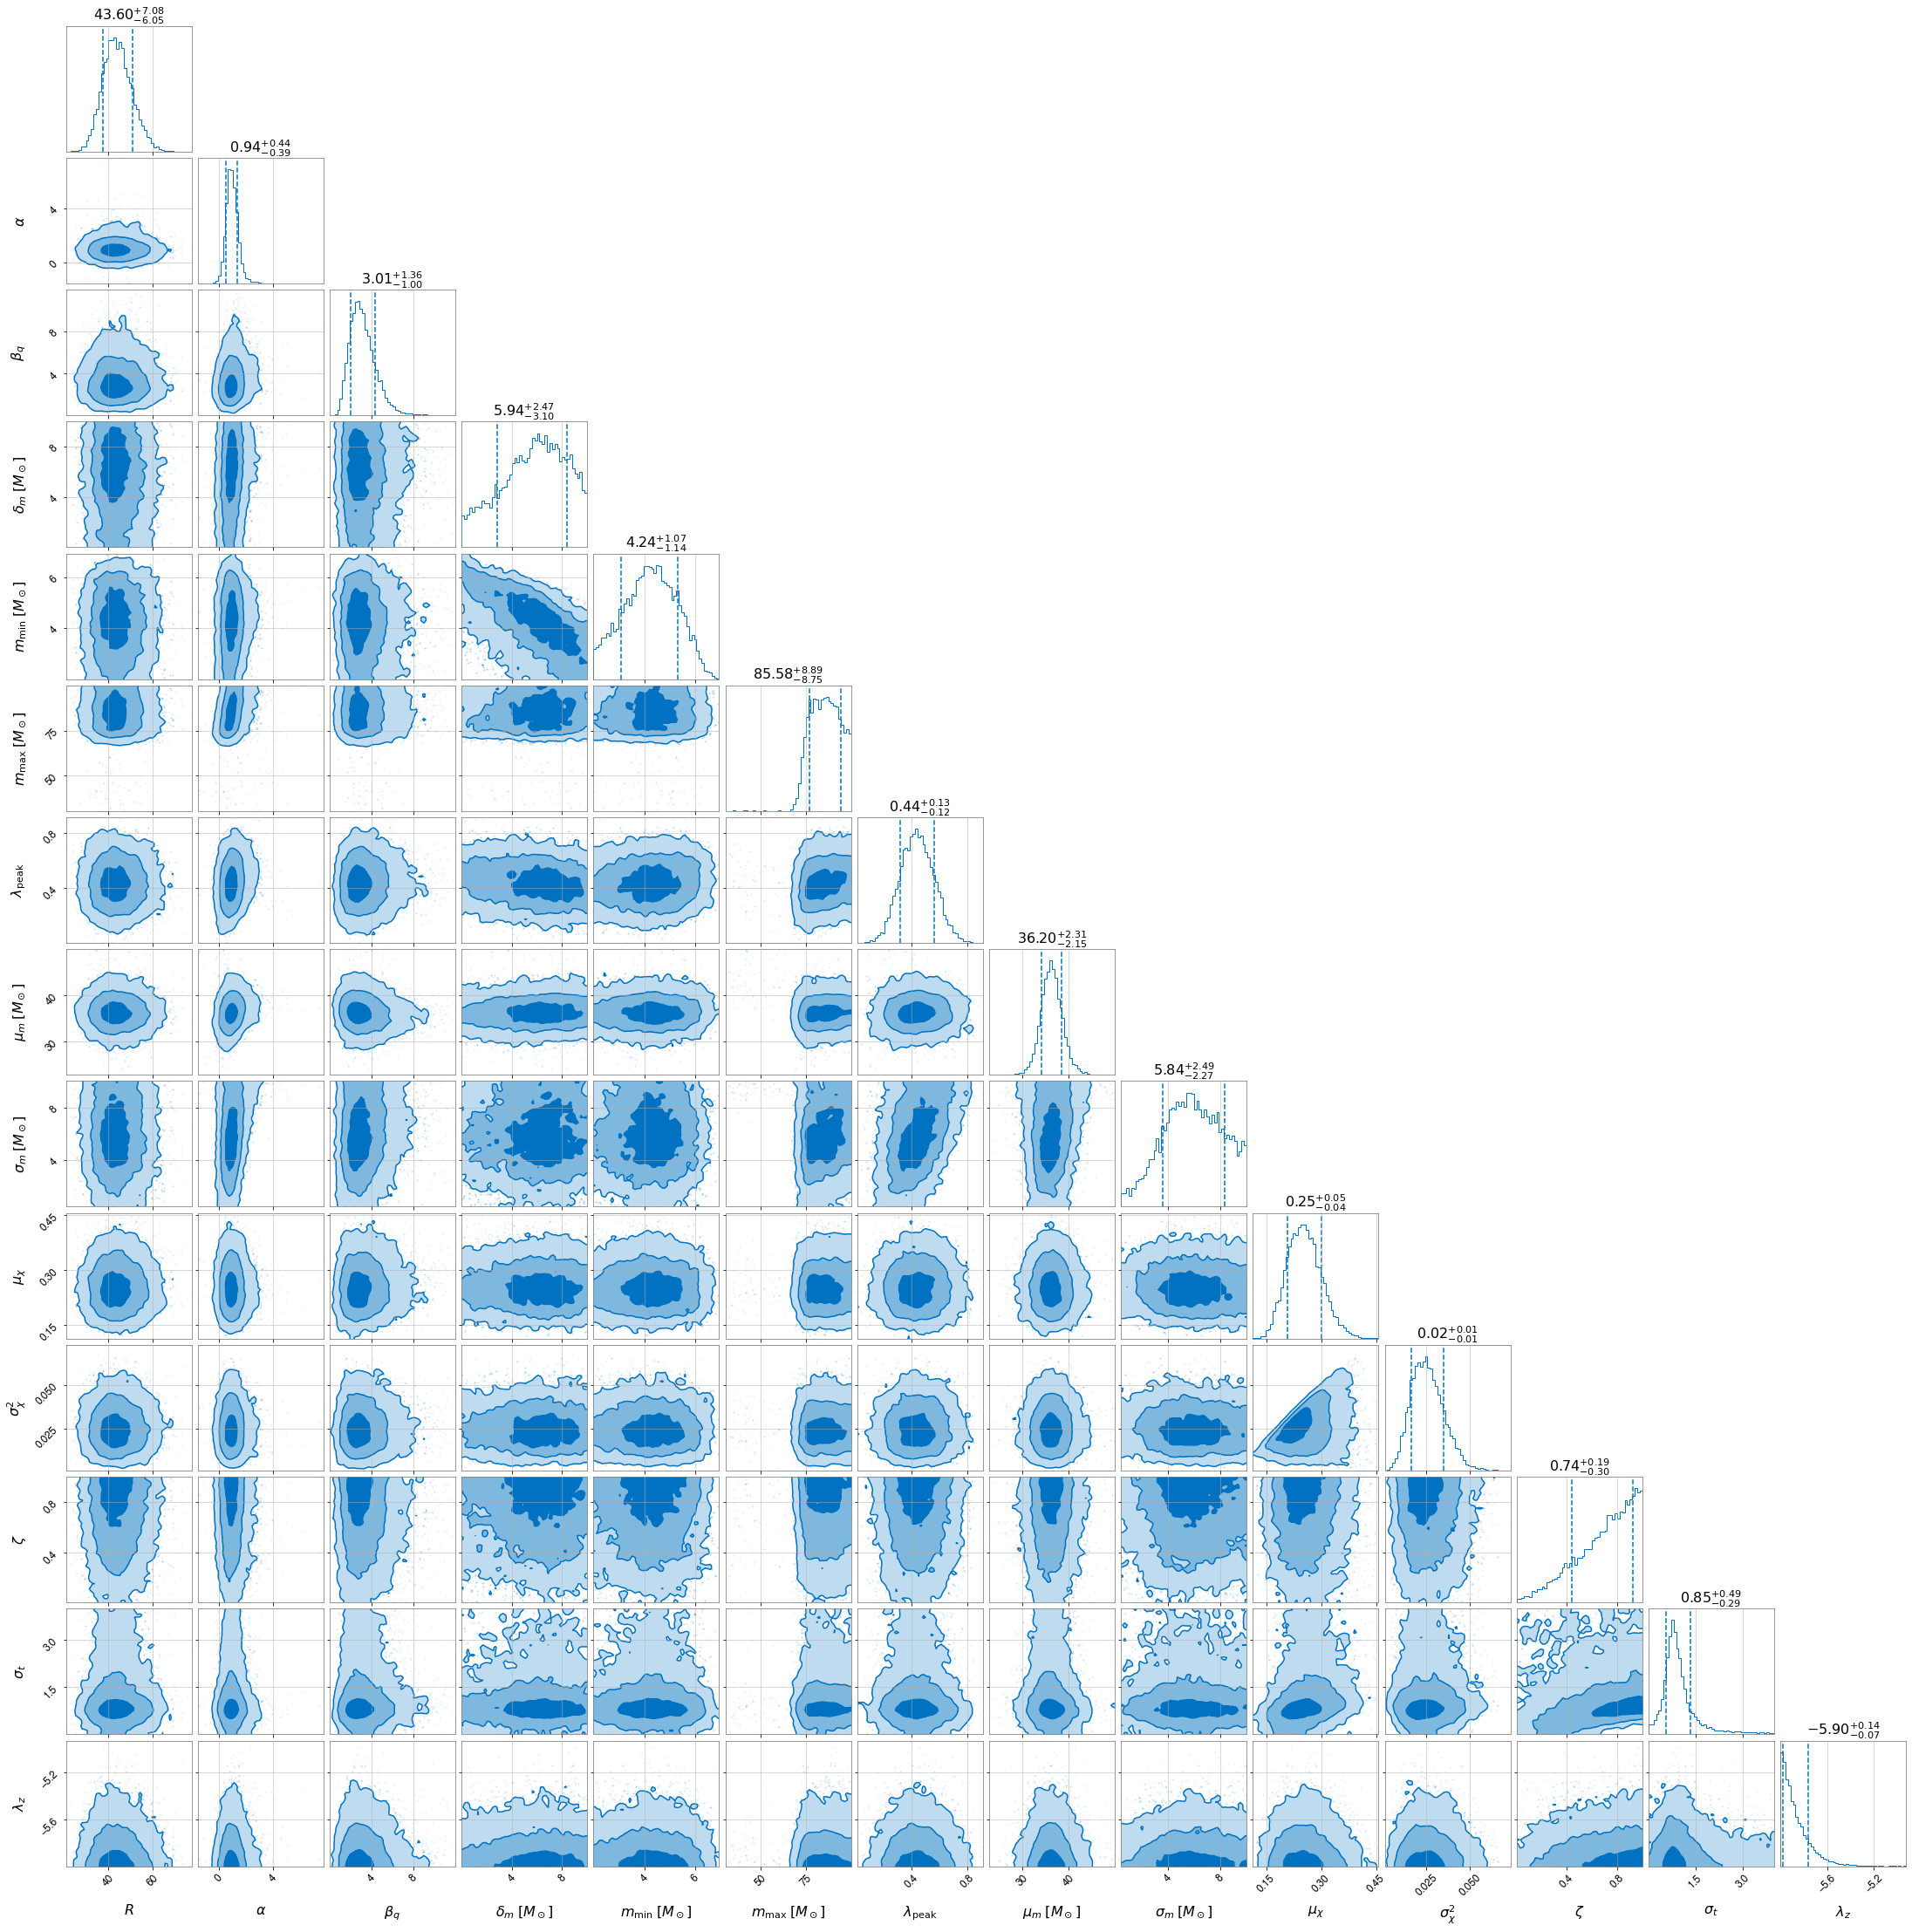

In [11]:
result.plot_corner()

xi_spin mu_chi 0.02609994763971855
xi_spin sigma_chi 0.02327091797992632
xi_spin sigma_spin 0.04342188749774395
mu_chi sigma_chi 0.011227200943100958
mu_chi sigma_spin 0.020949163100760417
sigma_chi sigma_spin 0.018678438094795795


/home/deepnika.jain/O3a/Default/plots.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i))
/home/deepnika.jain/O3a/Default/plots.py:53: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i + (j+1)*ndim))


xi_spin mu_chi 0.02209159836948784
xi_spin sigma_chi 0.019020597693156945
xi_spin sigma_spin 0.03891233770400013


/home/deepnika.jain/O3a/Default/plots.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i))
/home/deepnika.jain/O3a/Default/plots.py:53: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i + (j+1)*ndim))


mu_chi sigma_chi 0.008801065652612086
mu_chi sigma_spin 0.018005219623184


/home/deepnika.jain/O3a/Default/plots.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i))
/home/deepnika.jain/O3a/Default/plots.py:53: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i + (j+1)*ndim))


sigma_chi sigma_spin 0.015502275258748395


/home/deepnika.jain/O3a/Default/plots.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i))


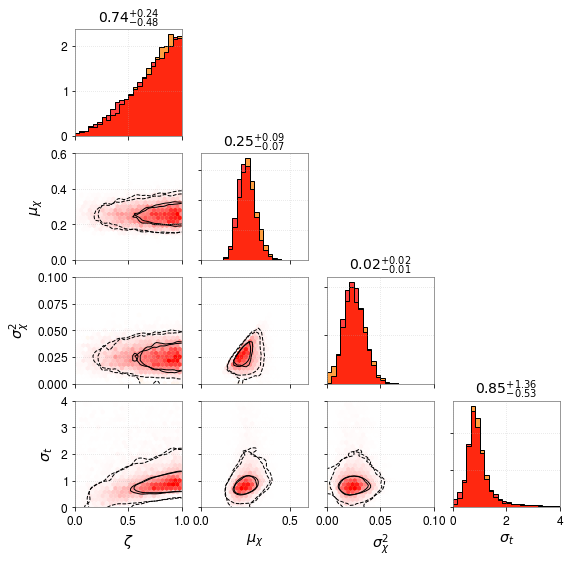

In [12]:
overlayed_plot_default("Results/O3a_LIGO_default_results/O3a_LIGO_default_results.json", 
                       "Results/default_spin_mass_redshift/default_spin_mass_redshift_result.json", 
                       "default_spin_mass_redshift", save = True)